In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [21]:
import xlwings as xw

# View the current data open in Excel
curr_data = array(xw.Range('A17:C33').value)
curr_data

array([[ 20.   ,  24.   ,   1.95 ],
       [ 25.   ,  25.01 ,   1.83 ],
       [ 30.   ,  25.89 ,   1.69 ],
       [ 35.   ,  26.89 ,   1.54 ],
       [ 40.   ,  27.55 ,   1.398],
       [ 45.   ,  28.1  ,   1.276],
       [ 50.   ,  28.45 ,   1.251],
       [ 53.   ,  28.62 ,   1.291],
       [ 54.   ,  28.74 ,   1.35 ],
       [ 55.   ,  28.74 ,   1.42 ],
       [ 56.   ,  28.74 ,   1.48 ],
       [ 57.   ,  28.64 ,   1.555],
       [ 60.   ,  28.36 ,   1.847],
       [ 65.   ,  27.27 ,   3.   ],
       [ 70.   ,  24.85 ,   5.06 ],
       [ 75.   ,  21.71 ,   8.2  ],
       [ 80.   ,  16.56 ,  15.54 ]])

In [22]:
angle_deg = array(curr_data[:,0])
intensity_mV = array(curr_data[:,2])

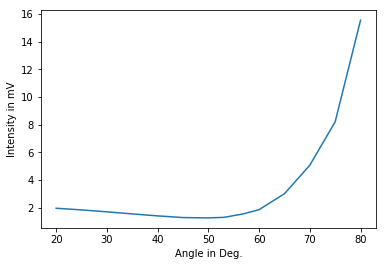

In [23]:
# A quick plot of the data yields
plot(angle_deg, intensity_mV)
xlabel('Angle in Deg.')
ylabel('Intensity in mV')

In [38]:
n_1 = 1

## Gradients and differentiation rules

Note that
$$
\ell \equiv \sqrt{1-\left(\frac{n_1}{n_2}\sin\theta_i\right)^2} = \cos\theta_t
$$
such that
$$
\frac{d\ell}{dn_2} = \frac{n_1 \sin\theta_i}{n_2^3\sqrt{\ell}}
$$

In [16]:
def d_division(u, v, du, dv):
    return (du*v - dv*u)/(v*v)

def d_multiplication(u, v, du, dv):
    return u*dv + du*v

def l_funct(angle_i_rad, n_1, n_2):
    return sqrt(1 - (n_1/n_2*sin(angle_i_rad))**2)

def l_grad(angle_i_rad, n_1, n_2):
    return n_1*sin(angle_i_rad)/(n_2**3 * l_funct(angle_i_rad, n_1, n_2))

In [58]:
def Rp(angle_i_rad, n_1, n_2):
    l = l_funct(angle_i_rad, n_1, n_2)
    costi = cos(angle_i_rad)
    return ((n_1*l - n_2*costi)/(n_1*l + n_2*costi))**2

def grad_Rp(angle_i_rad, n_1, n_2):
    l = l_funct(angle_i_rad, n_1, n_2)
    dl = l_grad(angle_i_rad, n_1, n_2)
    costi = cos(angle_i_rad)
    u = n_1*l - n_2*costi
    v = n_1*l + n_2*costi
    du = n_1*dl - costi
    dv = n_1*dl + costi
    
    d_div = d_division(u, v, du, dv)
    
    
    return 2*(n_1*l - n_2*costi)/(n_1*l + n_2*costi)*d_div

def sqrt_likelihood(angle_i_rad, n_1, n_2, coef, intensity_au):
    rp = Rp(angle_i_rad, n_1, n_2)
    return coef*rp - intensity_au

def likelihood_grad_n2(angle_i_rad, n_1, n_2, coef, intensity_au):
    l = sqrt_likelihood(angle_i_rad, n_1, n_2, coef, intensity_au)
    d_rp = grad_Rp(angle_i_rad, n_1, n_2)
    return 2*l*d_rp

def likelihood_grad_coef(angle_i_rad, n_1, n_2, coef, intensity_au):
    l = sqrt_likelihood(angle_i_rad, n_1, n_2, coef, intensity_au)
    rp = Rp(angle_i_rad, n_1, n_2)
    return 2*l*rp

Current error : 364.3735
Current error : 24.7658
Current error : 24.5438
Current error : 24.5436
Current error : 24.5436
Error change below threshold (eps = 0.00000), breaking.
Found A : 68.926 and n_2 : 1.453


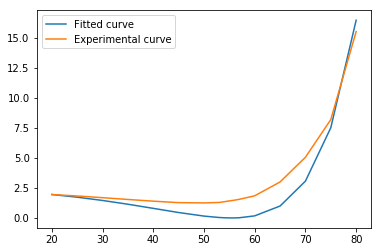

In [69]:
n2_init = 1.5
A_init = 1
learning_rate = .005

A = A_init
n_2 = n2_init

N = 100000
N_update = N/20

old_err, new_err = 1e9, 1e9

for i in range(N):
    if i%N_update == 0:
        error = 0
        for angle, I in zip(angle_deg, intensity_mV):
            angle_rad = angle*pi/180
            error += sqrt_likelihood(angle_rad, n_1, n_2, A, I)**2
        old_err, new_err = new_err, error
        print('Current error : {:.4f}'.format(error))
        err_change = abs(old_err - new_err)
        if err_change < 1e-4:
            print('Error change below threshold (eps = {:.3e}), breaking.'.format(err_change))
            break
    
    for angle, I in zip(angle_deg, intensity_mV):
        angle_rad = angle*pi/180
        n_2_update = learning_rate*likelihood_grad_n2(angle_rad, n_1, n_2, A, I)
        A -= learning_rate*likelihood_grad_coef(angle_rad, n_1, n_2, A, I)
        n_2 -= n_2_update
        

print('Found A : {:.3f} and n_2 : {:.3f}'.format(A, n_2))
        
rp_out = []
for angle in angle_deg:
    angle_rad = angle*pi/180
    rp_out.append(A*Rp(angle_rad, n_1, n_2))

plot(angle_deg, rp_out, label='Fitted curve')
plot(angle_deg, intensity_mV, label='Experimental curve')
legend()
# savefig('some_results.png', dpi=600)